# LeNet Lab
![LeNet Architecture](lenet.png)
Source: Yan LeCun

In [1]:
import time
from functools import wraps

PROF_DATA = {}

def profile(fn):
    @wraps(fn)
    def with_profiling(*args, **kwargs):
        start_time = time.time()

        ret = fn(*args, **kwargs)

        elapsed_time = time.time() - start_time

        if fn.__name__ not in PROF_DATA:
            PROF_DATA[fn.__name__] = [0, []]
            
        PROF_DATA[fn.__name__][0] += 1
        PROF_DATA[fn.__name__][1].append(elapsed_time)

        return ret

    return with_profiling

def print_prof_data():
    for fname, data in PROF_DATA.items():
        max_time = max(data[1])
        avg_time = sum(data[1]) / len(data[1])
        print('Function {} called {} times.'.format(fname, data[0]))
        print('Execution time max: {:.3f}, average: {:.3f}'.format(max_time, avg_time))

def clear_prof_data():
    global PROF_DATA
    PROF_DATA = {}

## Load Data

Load the MNIST data, which comes pre-loaded with TensorFlow.

You do not need to modify this section.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Image Shape: (28, 28, 1)

Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.

However, the LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).

You do not need to modify this section.

In [3]:
import numpy as np

# Pad images with 0s
X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 1)


## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def display_images(dataset, n_cols, titles = None, height = 5):
    elements_num = len(dataset)
    n_rows = math.ceil(elements_num / n_cols) + 1
    
    plt.figure(figsize = (20, height))
    plt.suptitle("Slice element {}".format(dataset[0].shape))
    
    for i in range(0, elements_num):
        element = dataset[i]
        depth = element.shape[-1]
        
        plt.subplot(n_rows, n_cols, i + 1)
        plt.axis('off')
        
        if titles is None:
            plt.title('Element ' + str(i))
        else:
            plt.title(titles[i])
            
        if depth == 1:
            plt.imshow(element.squeeze(), cmap="gray") 
        else:
            plt.imshow(element.squeeze())
            
    plt.show()
    
def display_tensor(tensor, n_cols = 6, title = "Draw tensor"):
    filters = tensor.shape[3]
    n_rows = math.ceil(filters / n_cols) + 1
    
    plt.figure(figsize = (20, 8))
    plt.suptitle(title + ', Shape ' + str(tensor.shape))
    
    for i in range(filters):
        element = tensor[0, :, :, i]
        
        plt.subplot(n_rows, n_cols, i + 1)
        plt.axis('off')
        plt.title('Iteration ' + str(i))
        plt.imshow(element, interpolation = "nearest", cmap = "gray")
        
def visualize(x, title):
    res = sess.run(x)
    display_tensor(res, 6, title = title)

## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [5]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [6]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

## TODO: Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [7]:
from tensorflow.contrib.layers import flatten

def conv(x, k_size, depth, mu, sigma):
    prev_shape = x.get_shape()
    prev_depth = prev_shape[-1]

    weights = tf.Variable(tf.truncated_normal(shape = [k_size, k_size, int(prev_depth), depth], mean = mu, stddev = sigma))
    bias = tf.Variable(tf.truncated_normal([depth]))
    conv = tf.nn.conv2d(x, weights, strides = [1, 1, 1, 1], padding = 'VALID')
    return tf.nn.bias_add(conv, bias)

def relu(x):
    return tf.nn.relu(x)

def max_pool(x, k_size, stride):
    return tf.nn.max_pool(x, ksize = [1, k_size, k_size, 1], strides = [1, stride, stride, 1], padding = 'SAME')
    
def flatten(x):
    shape = x.get_shape()[1:]
    return tf.reshape(x, [-1, int(shape[0] * shape[1] * shape[2])])
    
def fcl(x, out, mu, sigma):
    weights = tf.Variable(tf.truncated_normal(shape = [x.get_shape()[1].value, out], mean = mu, stddev = sigma))
    bias = tf.Variable(tf.truncated_normal([out]))
    return tf.add(tf.matmul(x, weights), bias)

def LeNet(x, test = False):    
    # X shape = (55000, 32, 32, 1) =7 (batch, height, width, channels)
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    layer1 = conv(x, 5, 6, mu, sigma) # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    layer1 = relu(layer1) # Activation.
    layer1 = max_pool(layer1, 2, 2) # Pooling. Input = 28x28x6. Output = 14x14x6.
    
    layer2 = conv(layer1, 5, 16, mu, sigma) # Layer 2: Convolutional. Output = 10x10x16.
    layer2 = relu(layer2) # Activation.
    layer2 = max_pool(layer2, 2, 2) # Pooling. Input = 10x10x16. Output = 5x5x16.
    
    flat = flatten(layer2) # Flatten. Input = 5x5x16. Output = 400.
    
    layer3 = fcl(flat, 120, mu, sigma) # Layer 3: Fully Connected. Input = 400. Output = 120.
    layer3 = relu(layer3) # Activation.

    layer4 = fcl(layer3, 84, mu, sigma) # Layer 4: Fully Connected. Input = 120. Output = 84.
    layer4 = relu(layer4) # Activation.

    logits = fcl(layer4, 10, mu, sigma) # Layer 5: Fully Connected. Input = 84. Output = 10.

    if test:
        return layer1, layer2, flat, layer3, layer4, logits
    else:
        return logits

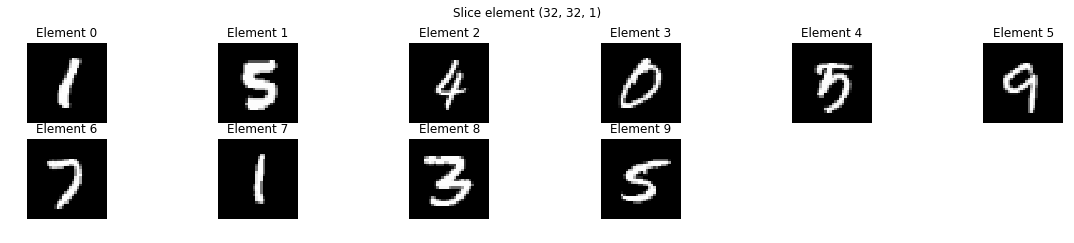

Flat (10, 400)
Layer 3 (10, 120)
Layer 4 (10, 84)
Logits (10, 10)


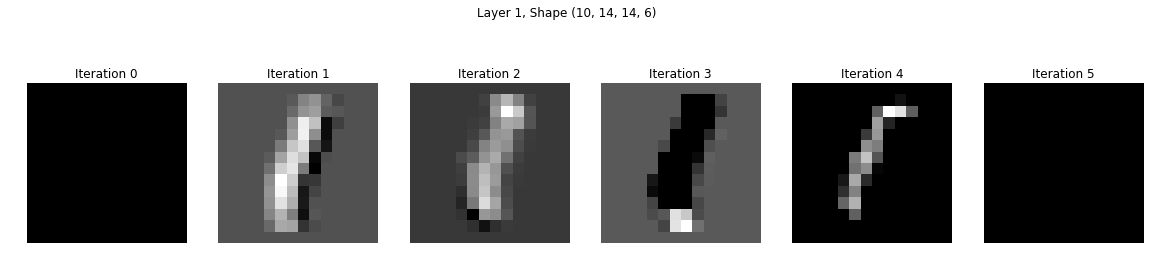

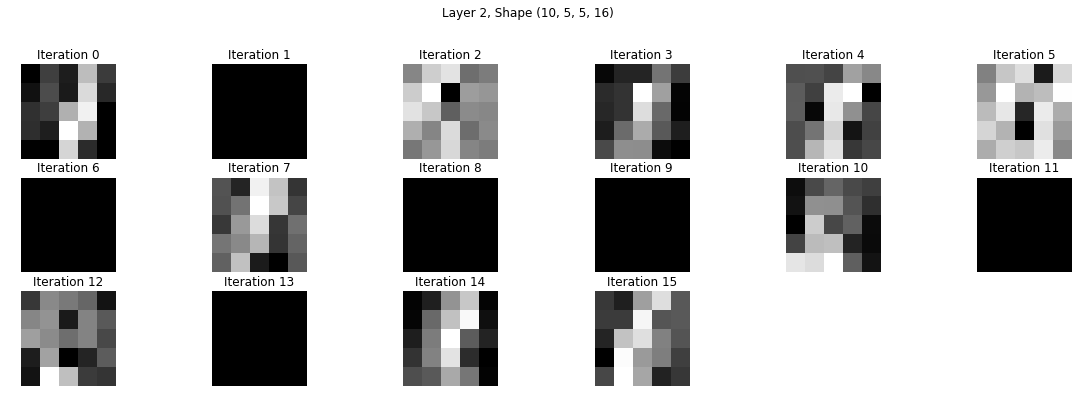

In [8]:
import matplotlib.gridspec as gridspec
import math

x_slice = 10
dataset = X_train[0:x_slice]
display_images(dataset, 6)
dataset = tf.Variable(dataset)
layer1, layer2, flat, layer3, layer4, logits = LeNet(dataset, True)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    res = sess.run(layer1)
    display_tensor(res, 6, title = "Layer 1")
    
    res = sess.run(layer2)
    display_tensor(res, 6, title = "Layer 2")
    
    res = sess.run(flat)
    print("Flat", res.shape)
    
    res = sess.run(layer3)
    print("Layer 3", res.shape)
    
    res = sess.run(layer4)
    print("Layer 4", res.shape)
    
    res = sess.run(logits)
    print("Logits", res.shape)

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [11]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def evaluate_draw(X_data, y_data):
    sess = tf.get_default_session()
    res = [tf.argmax(logits, 1), tf.argmax(one_hot_y, 1)]
    result = sess.run(res, feed_dict={x: X_data, y: y_data})
    
    titles = []
    
    for predicted, truth in zip(result[0], result[1]):
        titles.append('Logit {}, Truth {}'.format(predicted, truth))
        
    display_images(X_data, 6, titles = titles, height = 15)

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [13]:
@profile
def run_session(sess, X_train, y_train):
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")
    
with tf.Session() as sess:
    run_session(sess, X_train, y_train)
    
print_prof_data()

Training...

EPOCH 1 ...
Validation Accuracy = 0.935

EPOCH 2 ...
Validation Accuracy = 0.968

EPOCH 3 ...
Validation Accuracy = 0.974

EPOCH 4 ...
Validation Accuracy = 0.981

EPOCH 5 ...
Validation Accuracy = 0.980

EPOCH 6 ...
Validation Accuracy = 0.981

EPOCH 7 ...
Validation Accuracy = 0.980

EPOCH 8 ...
Validation Accuracy = 0.983

EPOCH 9 ...
Validation Accuracy = 0.986

EPOCH 10 ...
Validation Accuracy = 0.988

Model saved
Function run_session called 1 times.
Execution time max: 465.396, average: 465.396


## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

Test Accuracy = 0.985


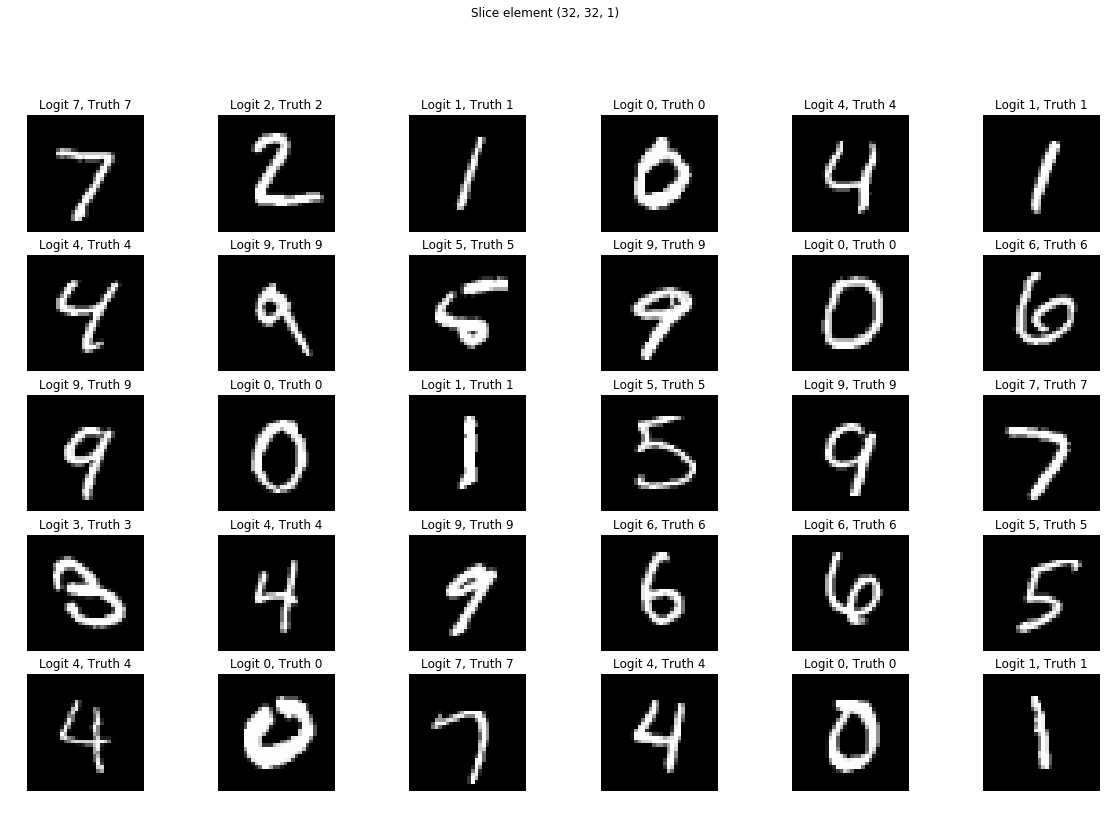

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    evaluate_draw(X_test[:30], y_test[:30])